In [1]:
from NPHM.models.deepSDF import DeepSDF, DeformationNetwork
from NPHM.models.EnsembledDeepSDF import FastEnsembleDeepSDFMirrored
from NPHM import env_paths
from NPHM.utils.reconstruction import create_grid_points_from_bounds, mesh_from_logits
from NPHM.models.reconstruction import deform_mesh, get_logits, get_logits_backward
from NPHM.models.fitting import inference_iterative_root_finding_joint, inference_identity_space
from NPHM.data.manager import DataManager

import numpy as np
import argparse
import json, yaml
import os
import os.path as osp
import torch
import pyvista as pv
import matplotlib.pyplot as plt

In [2]:
resolution = 35

with open('scripts/configs/fitting_nphm.yaml', 'r') as f:
    print('Loading config file from: ' + 'scripts/configs/fitting_nphm.yaml')
    CFG = yaml.safe_load(f)

print(json.dumps(CFG, sort_keys=True, indent=4))

weight_dir_shape = env_paths.EXPERIMENT_DIR + '/{}/'.format(CFG['exp_name_shape'])

# load config files
fname_shape = weight_dir_shape + 'configs.yaml'
with open(fname_shape, 'r') as f:
    print('Loading config file from: ' + fname_shape)
    CFG_shape = yaml.safe_load(f)

Loading config file from: scripts/configs/fitting_nphm.yaml
{
    "checkpoint_expr": 2500,
    "checkpoint_shape": 15000,
    "exp_name_expr": "nphm_expression_space_pretrained",
    "exp_name_shape": "nphm_identity_space_pretrained",
    "lambdas_shape": {
        "reg_global": 0.002,
        "reg_unobserved": "5.0 0",
        "reg_zero": 0.005,
        "surface": 2.0,
        "symm_dist": 1.0
    },
    "local_expr": false,
    "local_shape": true,
    "mode": "compress"
}
Loading config file from: /Users/katharinaschmid/NPHM-main/katha//nphm_identity_space_pretrained/configs.yaml


In [3]:
device = torch.device("cpu")

In [4]:
print('###########################################################################')
print('####################     Shape Model Configs     #############################')
print('###########################################################################')
print(json.dumps(CFG_shape, sort_keys=True, indent=4))

lm_inds = np.load(env_paths.ANCHOR_INDICES_PATH)
anchors = torch.from_numpy(np.load(env_paths.ANCHOR_MEAN_PATH)).float().unsqueeze(0).unsqueeze(0).to(device)


###########################################################################
####################     Shape Model Configs     #############################
###########################################################################
{
    "anchors_path": "/cluster/daidalos/sgiebenhain/anchors_39.npy",
    "data": {
        "n_expressions": 1,
        "n_subjects": 300,
        "root": "/cluster/angmar/sgiebenhain/synth_data_2neutral"
    },
    "decoder": {
        "decoder_hidden_dim": 200,
        "decoder_lat_dim_glob": 64,
        "decoder_lat_dim_loc": 32,
        "decoder_nlayers": 4,
        "decoder_nloc": 39,
        "decoder_nsymm_pairs": 16,
        "dropout": false,
        "type": "deep_sdf_decoder",
        "weight_norm": false
    },
    "encoder": null,
    "lm_inds_path": "/cluster/daidalos/sgiebenhain/lm_inds_39.npy",
    "training": {
        "batch_size": 32,
        "ckpt_interval": 500,
        "grad_clip": 0.1,
        "grad_clip_lat": 0.1,
        "lambdas": {
   

In [5]:
decoder_shape = FastEnsembleDeepSDFMirrored(
        lat_dim_glob=CFG_shape['decoder']['decoder_lat_dim_glob'],
        lat_dim_loc=CFG_shape['decoder']['decoder_lat_dim_loc'],
        hidden_dim=CFG_shape['decoder']['decoder_hidden_dim'],
        n_loc=CFG_shape['decoder']['decoder_nloc'],
        n_symm_pairs=CFG_shape['decoder']['decoder_nsymm_pairs'],
        anchors=anchors,
        n_layers=CFG_shape['decoder']['decoder_nlayers'],
        pos_mlp_dim=CFG_shape['decoder'].get('pos_mlp_dim', 256),
    )

decoder_shape = decoder_shape.to(device)

path = osp.join(weight_dir_shape, 'checkpoints/checkpoint_epoch_{}.tar'.format(CFG['checkpoint_shape']))
print('Loaded checkpoint from: {}'.format(path))
checkpoint = torch.load(path, map_location=device)
decoder_shape.load_state_dict(checkpoint['decoder_state_dict'], strict=True)

if 'latent_codes_state_dict' in checkpoint:
    n_train_subjects = checkpoint['latent_codes_state_dict']['weight'].shape[0]
    n_val_subjects = checkpoint['latent_codes_val_state_dict']['weight'].shape[0]
    latent_codes_shape = torch.nn.Embedding(n_train_subjects, 512)
    latent_codes_shape_val = torch.nn.Embedding(n_val_subjects, 512)
    
    latent_codes_shape.load_state_dict(checkpoint['latent_codes_state_dict'])
    latent_codes_shape_val.load_state_dict(checkpoint['latent_codes_val_state_dict'])
else:
    print('no latent codes in state dict')
    latent_codes_shape = None
    latent_codes_shape_val = None

decoder_expr = None

Loaded checkpoint from: /Users/katharinaschmid/NPHM-main/katha//nphm_identity_space_pretrained/checkpoints/checkpoint_epoch_15000.tar
no latent codes in state dict


In [6]:
lat_mean = torch.from_numpy(np.load(env_paths.ASSETS + 'nphm_lat_mean.npy'))
lat_std = torch.from_numpy(np.load(env_paths.ASSETS + 'nphm_lat_std.npy'))

lat_rep = (torch.randn(lat_mean.shape) * lat_std * 0.85 + lat_mean)
print(lat_rep.shape) #40*32+64

mini = [-.55, -.5, -.95]
maxi = [0.55, 0.75, 0.4]

grid_points = create_grid_points_from_bounds(mini, maxi, resolution)
print(grid_points)
grid_points = torch.from_numpy(grid_points).to(device, dtype=torch.float)
grid_points = torch.reshape(grid_points, (1, len(grid_points), 3)).to(device)
print(grid_points.shape)

torch.Size([1344])
[[-0.55       -0.5        -0.95      ]
 [-0.55       -0.5        -0.91029412]
 [-0.55       -0.5        -0.87058824]
 ...
 [ 0.55        0.75        0.32058824]
 [ 0.55        0.75        0.36029412]
 [ 0.55        0.75        0.4       ]]
torch.Size([1, 42875, 3])


In [7]:
print(lat_rep.shape)
logits = get_logits(decoder_shape, lat_rep, grid_points, nbatch_points=100)
print('starting mcubes')



torch.Size([1344])
points
torch.Size([1, 100, 3])
encoding
torch.Size([1344])
points
torch.Size([1, 100, 3])
encoding
torch.Size([1344])
points
torch.Size([1, 100, 3])
encoding
torch.Size([1344])
points
torch.Size([1, 100, 3])
encoding
torch.Size([1344])
points
torch.Size([1, 100, 3])
encoding
torch.Size([1344])
points
torch.Size([1, 100, 3])
encoding
torch.Size([1344])
points
torch.Size([1, 100, 3])
encoding
torch.Size([1344])
points
torch.Size([1, 100, 3])
encoding
torch.Size([1344])
points
torch.Size([1, 100, 3])
encoding
torch.Size([1344])
points
torch.Size([1, 100, 3])
encoding
torch.Size([1344])
points
torch.Size([1, 100, 3])
encoding
torch.Size([1344])
points
torch.Size([1, 100, 3])
encoding
torch.Size([1344])


KeyboardInterrupt: 

done mcubes


/opt/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


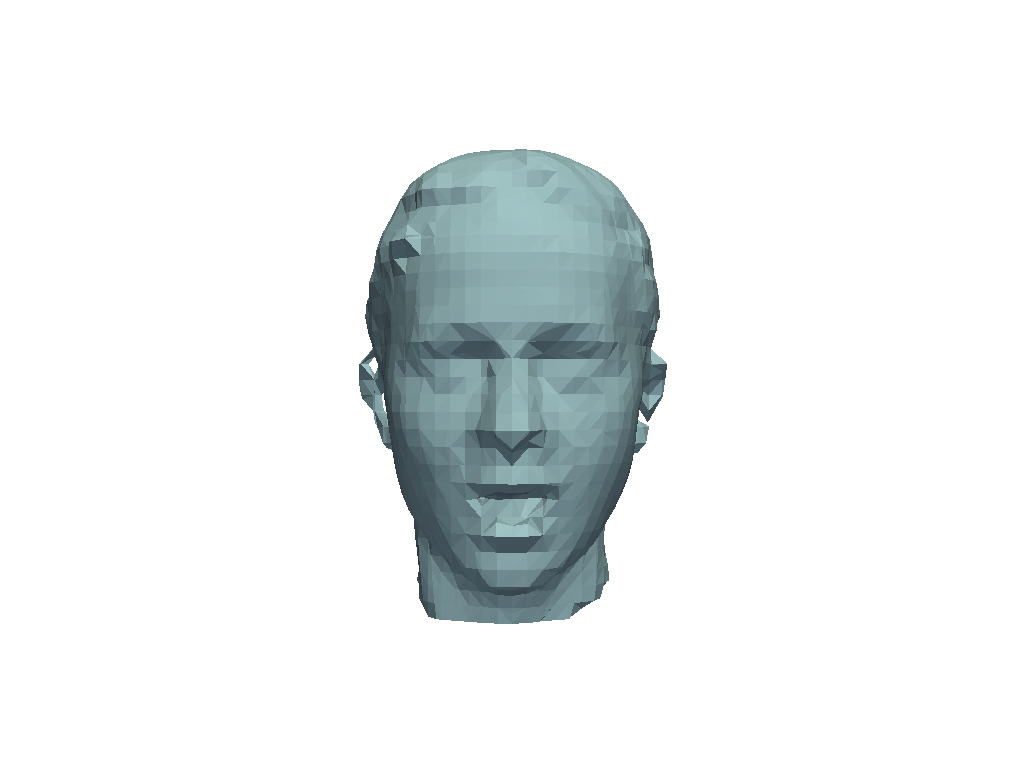

vtkOpenGLCamera (0x7febc5898a20)
  Debug: Off
  Modified Time: 2090
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (2.19481, 5.05781)
  DirectionOfProjection: (-3.35971e-05, 0.012768, -0.999918)
  Distance: 3.45861
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (-0.000111373, 0.0423256, -0.314699)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 0.895154
  Position: (4.82589e-06, -0.001834, 3.14363)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.863
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (3.35971e-05, -0.012768, 0.999918)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000022add00
    Debug: Off
    Modified Time: 53
    Reference Count: 1
    Registered Events: (none)
    El

In [8]:
mesh = mesh_from_logits(logits, mini, maxi, resolution)
print('done mcubes')

pl = pv.Plotter(off_screen=True)
pl.add_mesh(mesh)
pl.reset_camera()
pl.camera.position = (0, 0, 3)
pl.camera.zoom(1.4)
pl.set_viewup((0, 1, 0)) #vertical direction of camera = +Y axis
pl.camera.view_plane_normal = (-0, -0, 1) #camera is looking at XY plane
pl.show()
#pl.show(screenshot=out_dir + '/step_{:04d}.png'.format(step))
#mesh.export(out_dir + '/mesh_{:04d}.ply'.format(step))
print(pl.camera)

In [57]:
# Define rendering parameters
res = 50
camera_position = torch.tensor([0.0, 0.0, 3.0])
max_ray_length = 4 - 2.3

# Define phong model constants
ambient_coeff = 0.1
diffuse_coeff = 0.6
specular_coeff = 0.3
shininess = 32.0

# Define light inputs
light_position = torch.tensor([2.0, 1.0, 3.0])

# Create an empty image
image = torch.zeros((res, res, 3))
#image = 0.01 * torch.ones((res, res, 3))

def phong_model(normal, light_dir, view_dir):
    # Normalize all vectors
    normal = normal / torch.norm(normal, dim=-1)
    light_dir = light_dir / torch.norm(light_dir, dim=-1)
    view_dir = view_dir / torch.norm(view_dir, dim=-1)
    
    ambient = ambient_coeff
    diffuse = diffuse_coeff * torch.clamp(torch.sum(light_dir * normal, dim=-1), min=0.0)
    reflect_dir = light_dir - 2 * normal * torch.clamp(torch.sum(light_dir * normal, dim=-1), min=0.0)
    specular = specular_coeff * torch.pow(torch.clamp(torch.sum(reflect_dir * view_dir, dim=-1), min=0.0), shininess)

    return ambient + diffuse + specular

def estimate_normal(sdf, point, epsilon=1e-3):
    # Calculate the SDF value at the given point
    sdf_value = sdf(point)

    # Calculate SDF values at neighboring points
    sdf_dx = sdf(point + torch.tensor([epsilon, 0, 0]))
    sdf_dy = sdf(point + torch.tensor([0, epsilon, 0]))
    sdf_dz = sdf(point + torch.tensor([0, 0, epsilon]))

    # Calculate the gradient using finite differences
    gradient = torch.tensor([sdf_dx - sdf_value, sdf_dy - sdf_value, sdf_dz - sdf_value])

    # Normalize the gradient to obtain the estimated normal
    normal = gradient / torch.norm(gradient, p=2)
    
    return normal

def sdf_sphere(position, radius=0.75):
    return torch.norm(position, dim=-1) - radius

def sdf_nphm(position):
    position = position.unsqueeze(0).unsqueeze(0) # [1, N, 3], lat_rep [lat_dim]
    distance, _ = decoder_shape(position, lat_rep.repeat(1, position.shape[1], 1), None)
    return distance

def ray_march(camera_position, direction, max_length):
    position = camera_position + 2.3 * direction
    step_size = 0.01

    for _ in range(int(max_length / step_size)):
        distance = sdf_sphere(position)  # Replace with your SDF function
        #distance = sdf_nphm(position)
        if distance < 0.01:
            return position  # Ray hits the surface

        position += step_size * direction

    return None  # Ray misses the scene

# Rendering loop
for v in range(res):
    for u in range(res):
        # Normalize the xy value of the current pixel [-1, 1]
        u_norm = (2.0 * (u + 0.5) / res - 1.0)
        v_norm = 1.0 - 2.0 * (v + 0.5) / res
        u_norm = torch.tensor([u_norm])
        v_norm = torch.tensor([v_norm])
         # Calculate the ray direction for the current pixel
        direction_unn = torch.tensor([u_norm, v_norm, -3.0])
        direction = direction_unn / torch.norm(direction_unn, dim=-1)

        # Perform ray marching
        hit_position = ray_march(camera_position, direction, max_ray_length)

        # Color the pixel based on whether the ray hits an object
        if hit_position is not None:
            normal = estimate_normal(sdf_sphere, hit_position)
            light_dir = - (hit_position - light_position) # umdrehen, damit L*V >0
            view_dir = - (camera_position - hit_position) # umdrehen, damit dot product nicht kleienr null?
            reflection = phong_model(normal, light_dir, view_dir)
            # Assign a color for objects
            image[v, u] = reflection * torch.tensor([1.0, 1.0, 1.0])


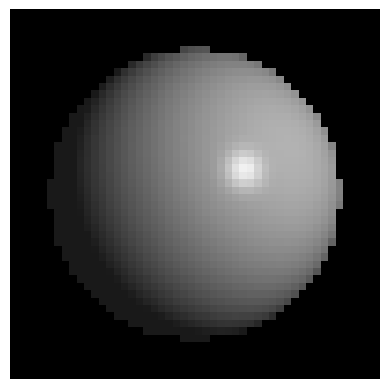

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [58]:
# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axes
plt.show()
print(image[:, :, 0])